In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [ ]:
# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#download dataset and store in data folder
dataset = CIFAR10(root='/content/drive/MyDrive/Colab Notebooks/data',train=True, download=True,transform=ToTensor())

Files already downloaded and verified


In [ ]:
print(dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
image, label = dataset[10]

image=image.permute(1,2,0)
print(image.shape)
cv2.imshow("image",image)
cv2.waitKey(0)

torch.Size([32, 32, 3])


DisabledFunctionError: ignored

image.shape: torch.Size([3, 32, 32])
Label: 4


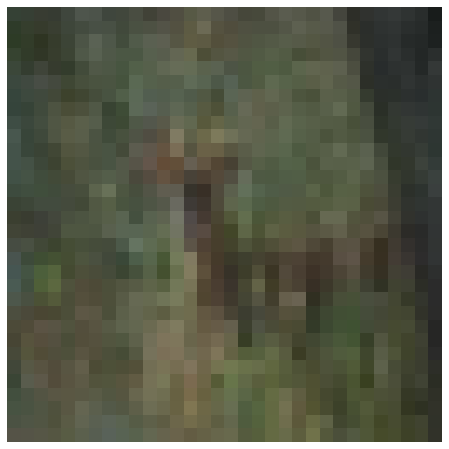

In [ ]:
image, label = dataset[10]
print('image.shape:', image.shape)
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(image.permute(1, 2, 0))#chenges the exis(H,W,C-1,2,0)
print('Label:', label)

In [ ]:
#prepering the traina nd validation split
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

In [ ]:
batch_size=128

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)# No. of subprocesses to use for data loading
val_loader=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)#If ipn_memory=True, the data loader will copy Tensors into CUDA pinned memory before returning them

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 32, 32])


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


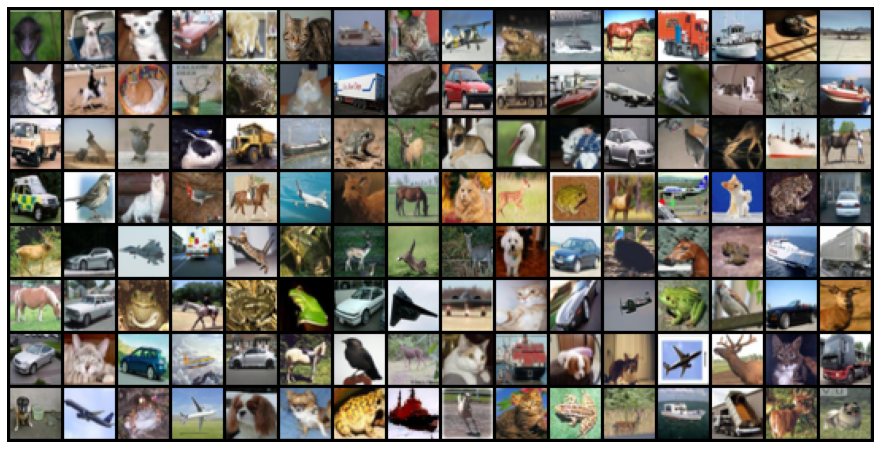

In [ ]:
#visualizing batch of data using make_grid from torchvision
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
class CifarModel(nn.Module):
    
    #to create two layers
    def __init__(self,in_size,hidden_size,out_size):
        super().__init__()
        self.linear1=nn.Linear(in_size,hidden_size)
        self.linear2=nn.Linear(hidden_size,out_size)

    #reshaping the input features
    def forward(self,xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        #print(xb)
        # Get intermediate outputs using hidden layer
        out=self.linear1(xb)

        # Apply activation function
        out=F.relu(out)

        #get predictions using output layer
        out=self.linear2(out) 

        return out

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):   
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc'])) 



In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    #print(preds)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
input_size = 3072
hidden_size = 32 # you can change this
num_classes = 10

In [ ]:
model = CifarModel(input_size, hidden_size=32, out_size=num_classes)

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 3072])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
#Batsch of first 128 images passed to model
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

In [ ]:
torch.cuda.is_available()#checking for GPU mode

True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
      return torch.device('cuda')
    else:
      return torch.device('cpu')  

In [ ]:
device = get_default_device()
print(device)

cuda


In [ ]:
#function that can move data and model to a chosen device.
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data,(list,tuple)):
       return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)   

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    images=to_device(images,device)
    print(images.device)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 3, 32, 32])
cuda:0


In [ ]:
#we define a DeviceDataLoader class to wrap our existing data loaders and move batches of data to the selected device.

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
      self.dl=dl
      self.device=device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device) #The yield keyword in Python is used to create a generator function that can be used within a for loop.



    def __len__(self):
        """Number of batches"""
        return len(self.dl)          

In [ ]:
#wrap our data loaders using DeviceDataLoader
train_loader=DeviceDataLoader(train_loader,device)
val_loader=DeviceDataLoader(val_loader,device)

In [ ]:
for im,label in train_loader:
  print(im.device)
  print(label)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


cuda:0
tensor([7, 2, 8, 1, 6, 0, 2, 6, 3, 2, 4, 9, 0, 1, 4, 1, 2, 3, 4, 9, 8, 6, 4, 5,
        2, 4, 2, 0, 7, 7, 5, 7, 2, 8, 4, 4, 6, 7, 7, 6, 5, 9, 9, 6, 6, 9, 0, 6,
        5, 6, 9, 4, 0, 2, 4, 8, 6, 2, 3, 6, 6, 8, 9, 4, 4, 8, 1, 6, 2, 2, 9, 9,
        5, 2, 3, 3, 4, 7, 7, 8, 6, 7, 6, 2, 4, 0, 6, 0, 1, 7, 3, 7, 7, 2, 7, 4,
        2, 9, 8, 1, 0, 8, 3, 1, 4, 1, 7, 4, 2, 8, 9, 3, 1, 1, 3, 2, 0, 2, 1, 1,
        7, 5, 7, 5, 7, 5, 2, 6], device='cuda:0')


In [ ]:
#Training the model
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history    

In [ ]:
# Model (on GPU)
model = CifarModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

CifarModel(
  (linear1): Linear(in_features=3072, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history += fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.3037, val_acc: 0.0953
Epoch [1], val_loss: 2.3032, val_acc: 0.1035
Epoch [2], val_loss: 2.3050, val_acc: 0.0953
Epoch [3], val_loss: 2.3026, val_acc: 0.1041
Epoch [4], val_loss: 2.3029, val_acc: 0.1037


In [ ]:
history+= fit(5, 0.01, model, train_loader, val_loader)
print(history)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.3028, val_acc: 0.0978
Epoch [1], val_loss: 2.3028, val_acc: 0.0978
Epoch [2], val_loss: 2.3028, val_acc: 0.0978
Epoch [3], val_loss: 2.3028, val_acc: 0.0978
Epoch [4], val_loss: 2.3028, val_acc: 0.0978
[{'val_loss': 2.3034017086029053, 'val_acc': 0.09775390475988388}, {'val_loss': 2.3031489849090576, 'val_acc': 0.09775390475988388}, {'val_loss': 2.3030049800872803, 'val_acc': 0.09775390475988388}, {'val_loss': 2.3029141426086426, 'val_acc': 0.09775390475988388}, {'val_loss': 2.3028557300567627, 'val_acc': 0.09775390475988388}, {'val_loss': 2.3028247356414795, 'val_acc': 0.09775390475988388}, {'val_loss': 2.3028104305267334, 'val_acc': 0.09775390475988388}, {'val_loss': 2.3028008937835693, 'val_acc': 0.09775390475988388}, {'val_loss': 2.30279803276062, 'val_acc': 0.09775390475988388}, {'val_loss': 2.302793264389038, 'val_acc': 0.09775390475988388}]


In [ ]:
history+= fit(5, 0.001, model, train_loader, val_loader)
print(history)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.3028, val_acc: 0.0978
Epoch [1], val_loss: 2.3028, val_acc: 0.0978
Epoch [2], val_loss: 2.3028, val_acc: 0.0978
Epoch [3], val_loss: 2.3028, val_acc: 0.0978
Epoch [4], val_loss: 2.3028, val_acc: 0.0978
[{'val_loss': 2.3034017086029053, 'val_acc': 0.09775390475988388}, {'val_loss': 2.3031489849090576, 'val_acc': 0.09775390475988388}, {'val_loss': 2.3030049800872803, 'val_acc': 0.09775390475988388}, {'val_loss': 2.3029141426086426, 'val_acc': 0.09775390475988388}, {'val_loss': 2.3028557300567627, 'val_acc': 0.09775390475988388}, {'val_loss': 2.3028247356414795, 'val_acc': 0.09775390475988388}, {'val_loss': 2.3028104305267334, 'val_acc': 0.09775390475988388}, {'val_loss': 2.3028008937835693, 'val_acc': 0.09775390475988388}, {'val_loss': 2.30279803276062, 'val_acc': 0.09775390475988388}, {'val_loss': 2.302793264389038, 'val_acc': 0.09775390475988388}, {'val_loss': 2.302793264389038, 'val_acc': 0.09775390475988388}, {'val_loss': 2.30279278755188, 'val_acc': 0.09775390

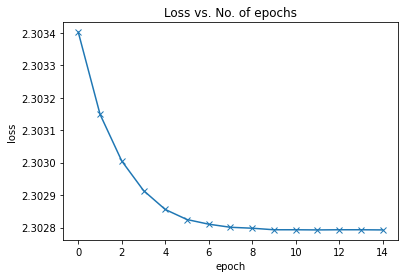

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

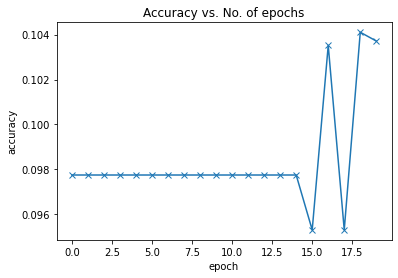

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
# Define test dataset
test_dataset = CIFAR10(root='/content/drive/MyDrive/Colab Notebooks/data', 
                     train=False,
                     transform=ToTensor())

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

torch.Size([3, 32, 32])


RuntimeError: ignored

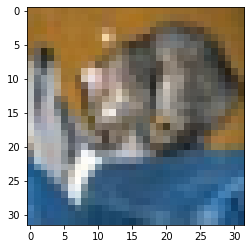

In [ ]:
img, label = test_dataset[0]
print(img.shape)
plt.imshow(img.permute(1, 2, 0))
print('Label:', label, ', Predicted:', predict_image(img.permute(1, 2, 0), model))